Python実践データ分析100本ノック（秀和システム）の勉強記録を載せています。<br>
問題の解説、コードを載せています。参考になれば幸いです。<br>
わからない点等ございましたらコメントお願いします。¶

# 第6章　物流の最適ルートをコンサルティングする

輸送最適化を検討するにあたっての基礎的技術を習得する。<br>
さらに、**実際の物流データからネットワーク構造を可視化する方法**について学び、最適な物流計画を立案する流れを学ぶ。

* ### 前提条件

部品を保管する倉庫から生産向上に部品を輸送している。各倉庫と工場の区間の輸送コストは過去のデータから定量的に設定されている。<br>
集計期間は2019年1月1日〜2019年12月31日まで。<br>
関東支社と東北支社のデータが存在するものとする。

| No. | ファイル名 | 概要 |
| :-- | :-- | :-- |
| 1 | tbl_factory.csv | 生産工場のデータ |
| 2 | tbl_warehouse.csv | 倉庫のデータ |
| 3 | rel_cost.csv | 倉庫と工場間の輸送コスト |
| 4 | tbl_transaction.csv | 2019年の工場への部品輸送実績 |

## ノック51 : 物流に関するデータを読み込む

In [1]:
import pandas as pd

factories = pd.read_csv('../input/python100knock-logistic/tbl_factory.csv', index_col=0)
print(len(factories))
factories

8


,FCName,FCDemand,FCRegion
FCID,,,
FC00001,東京工場,28,関東
FC00002,木更津工場,29,関東
FC00003,多摩工場,31,関東
FC00004,横須賀工場,25,関東
FC00005,仙台工場,21,東北
FC00006,山形工場,30,東北
FC00007,那須工場,25,東北
FC00008,青森工場,16,東北


In [2]:
warehouses = pd.read_csv('../input/python100knock-logistic/tbl_warehouse.csv', index_col=0)
print(len(warehouses))
warehouses

6


,WHName,WHSupply,WHRegion
WHID,,,
WH00001,杉並倉庫,35,関東
WH00002,品川倉庫,41,関東
WH00003,豊洲倉庫,42,関東
WH00004,郡山倉庫,60,東北
WH00005,仙台倉庫,72,東北
WH00006,山形倉庫,65,東北


In [3]:
cost = pd.read_csv('../input/python100knock-logistic/rel_cost.csv', index_col=0)
print(len(cost))
cost.head()

24


,FCID,WHID,Cost
RCostID,,,
1,FC00001,WH00001,0.4
2,FC00001,WH00002,0.8
3,FC00001,WH00003,1.5
4,FC00002,WH00001,0.9
5,FC00002,WH00002,0.8


In [4]:
trans = pd.read_csv('../input/python100knock-logistic/tbl_transaction.csv', index_col=0)
print(len(trans))
trans.head()

4000


,TransactionDate,ToFC,FromWH,Quantity
TRID,,,,
0,2019-01-01 02:11:10,FC00004,WH00003,33
1,2019-01-01 06:12:42,FC00007,WH00006,19
2,2019-01-01 06:32:32,FC00006,WH00004,31
3,2019-01-01 07:17:06,FC00002,WH00003,18
4,2019-01-01 07:52:18,FC00001,WH00002,30


輸送実績データ（trans）を元にして結合していく。

In [5]:
# 輸送コストデータを結合
join_data = pd.merge(trans, cost, left_on=['ToFC', 'FromWH'], right_on=['FCID','WHID'], how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8


In [6]:
# 工場のデータを付与する
join_data = pd.merge(join_data, factories, left_on='ToFC', right_on='FCID', how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東


In [7]:
# 倉庫の情報を付与
join_data = pd.merge(join_data, warehouses, left_on='FromWH', right_on='WHID', how='left')
join_data.head()

,TransactionDate,ToFC,FromWH,Quantity,FCID,WHID,Cost,FCName,FCDemand,FCRegion,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,FC00004,WH00003,33,FC00004,WH00003,1.1,横須賀工場,25,関東,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,FC00007,WH00006,19,FC00007,WH00006,1.3,那須工場,25,東北,山形倉庫,65,東北
2,2019-01-01 06:32:32,FC00006,WH00004,31,FC00006,WH00004,0.9,山形工場,30,東北,郡山倉庫,60,東北
3,2019-01-01 07:17:06,FC00002,WH00003,18,FC00002,WH00003,1.6,木更津工場,29,関東,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,FC00001,WH00002,30,FC00001,WH00002,0.8,東京工場,28,関東,品川倉庫,41,関東


In [8]:
# 見やすいように並び替えと列の削除を行う
join_data = join_data[['TransactionDate', 'Quantity', 'Cost', 'ToFC', 'FCName', 
                       'FCDemand', 'FromWH', 'WHName', 'WHSupply', 'WHRegion']]
join_data.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東


In [9]:
# 関東支社と東北支社のデータを抽出してみる
kanto = join_data.loc[join_data['WHRegion'] == '関東']
kanto.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
0,2019-01-01 02:11:10,33,1.1,FC00004,横須賀工場,25,WH00003,豊洲倉庫,42,関東
3,2019-01-01 07:17:06,18,1.6,FC00002,木更津工場,29,WH00003,豊洲倉庫,42,関東
4,2019-01-01 07:52:18,30,0.8,FC00001,東京工場,28,WH00002,品川倉庫,41,関東
7,2019-01-01 09:09:30,12,1.5,FC00001,東京工場,28,WH00003,豊洲倉庫,42,関東
8,2019-01-01 10:52:55,27,1.5,FC00003,多摩工場,31,WH00003,豊洲倉庫,42,関東


In [10]:
tohoku = join_data.loc[join_data['WHRegion'] == '東北']
tohoku.head()

,TransactionDate,Quantity,Cost,ToFC,FCName,FCDemand,FromWH,WHName,WHSupply,WHRegion
1,2019-01-01 06:12:42,19,1.3,FC00007,那須工場,25,WH00006,山形倉庫,65,東北
2,2019-01-01 06:32:32,31,0.9,FC00006,山形工場,30,WH00004,郡山倉庫,60,東北
5,2019-01-01 08:56:09,31,0.3,FC00005,仙台工場,21,WH00005,仙台倉庫,72,東北
6,2019-01-01 09:00:15,33,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北
9,2019-01-01 14:12:51,21,0.7,FC00006,山形工場,30,WH00006,山形倉庫,65,東北


## ノック52 : 現場の輸送量、コストを確認する

実際に一年間に輸送した部品数やそれにかかったコストを集計してみる。

* ### 各支社の総コスト

In [11]:
print('関東支社の総コスト' + str(kanto['Cost'].sum()) + '万円')
print('東北支社の総コスト' + str(tohoku['Cost'].sum()) + '万円')

関東支社の総コスト2189.3万円
東北支社の総コスト2062.0万円


* ### 各支社の総部品輸送個数

In [12]:
print('関東支社の総部品輸送個数' + str(kanto['Quantity'].sum()) + '個')
print('東北支社の総部品輸送個数' + str(tohoku['Quantity'].sum()) + '個')

関東支社の総部品輸送個数49146個
東北支社の総部品輸送個数50214個


* ### 部品一つあたりの輸送コストを求めてみる

In [13]:
tmp = (kanto['Cost'].sum() / kanto['Quantity'].sum()) * 10000
print('関東支社の部品一つあたりの輸送コスト : ' + str(int(tmp)) + '円')
tmp = (tohoku['Cost'].sum() / tohoku['Quantity'].sum()) * 10000
print('東北支社の部品一つあたりの輸送コスト : ' + str(int(tmp)) + '円')

関東支社の部品一つあたりの輸送コスト : 445円
東北支社の部品一つあたりの輸送コスト : 410円


* ### 各支社の輸送コストの平均値を出してみる


In [14]:
cost_chk = pd.merge(cost, factories, on='FCID', how='left')
print('関東支社の平均輸送コスト' + str(cost_chk['Cost'].loc[cost_chk['FCRegion'] == '関東'].mean()) + '万円')

print('東北支社の平均輸送コスト' + str(cost_chk['Cost'].loc[cost_chk['FCRegion'] == '東北'].mean()) + '万円')

関東支社の平均輸送コスト1.075万円
東北支社の平均輸送コスト1.05万円


各支社ごとに輸送コストはあまり変わらないことがわかった。<br>つまり、東北支社の方がより効率的に輸送を行うことができている。

## ノック53 : ネットワークを可視化する

* #### 最適化プログラムによって導き出されたプランを可視化するプロセス
* #### いくつかの条件を満たしていること

#### この二つを確認することで、現場の意思決定者が納得できる手法を提案することができる。

#### ネットワークの可視化を行うライブラリとして、NetworkXを使用する。

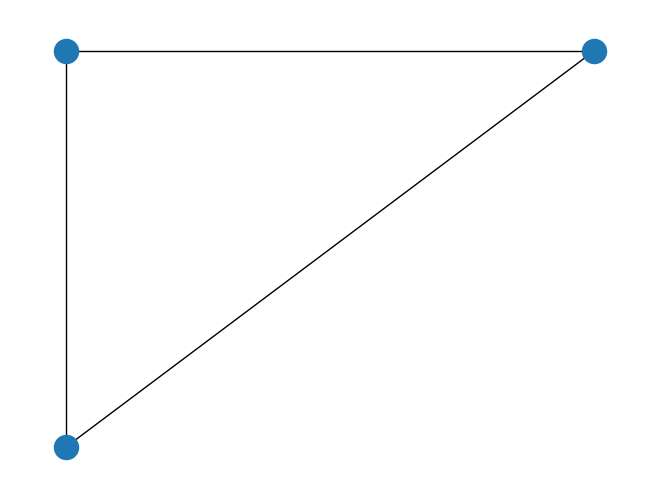

In [15]:
# ネットワーク構造の作成のデモ
import networkx as nx
import matplotlib.pyplot as plt

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点（ノード）の設定
G.add_node('nodeA')
G.add_node('nodeB')
G.add_node('nodeC')

# 辺の設定
G.add_edge('nodeA', 'nodeB')
G.add_edge('nodeA', 'nodeC')
G.add_edge('nodeB', 'nodeC')

# 座標の設定
pos={}
pos['nodeA'] = (0, 0)
pos['nodeB'] = (1, 1)
pos['nodeC'] = (0, 1)

# 描画
nx.draw(G, pos)

# 表示
plt.show()

## ノック54 : ネットワークにノード（頂点）を追加してみる

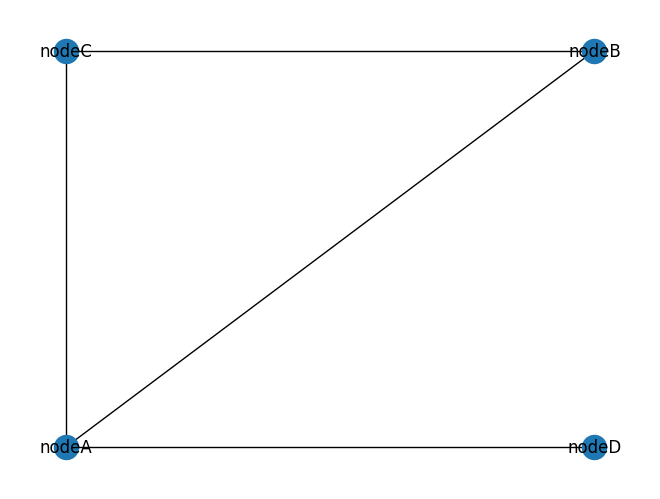

In [16]:
# ノードDを追加する
G.add_node('nodeD')
G.add_edge('nodeA', 'nodeD')
pos['nodeD'] = (1, 0)
# どこが増えたかわかるようにする
nx.draw(G, pos, with_labels=True)

## ノック55 : ルートの重みづけを実施する

CSVファイルに格納された重み情報をデータフレーム形式で読み込み、その数値を使って重みづけをする。

In [17]:
import numpy as np

# データの読み込み
df_w = pd.read_csv('../input/python100knock-logistic/network_weight.csv')
df_p = pd.read_csv('../input/python100knock-logistic/network_pos.csv')

# ノードの総数と、エッジの重みが格納されたデータ（縦列は0→A、1→Bのように読み替える）
# 値が0の部分は、ノードとノードが繋がっていないことを示す
df_w.head()

,A,B,C,D,E
0,0.000000,0.143353,0.944669,0.521848,0.000000
1,0.143353,0.000000,0.264556,0.456150,0.568434
2,0.944669,0.264556,0.000000,0.000000,0.617635
3,0.521848,0.456150,0.000000,0.000000,0.612096
4,0.000000,0.568434,0.617635,0.612096,0.000000


In [18]:
# 各ノードの座標データ
df_p.head()

,A,B,C,D,E
0,0,0,2,2,1
1,0,2,0,2,1


### 書籍に載っているコードに間違いがあります！下のコードを確認してください。

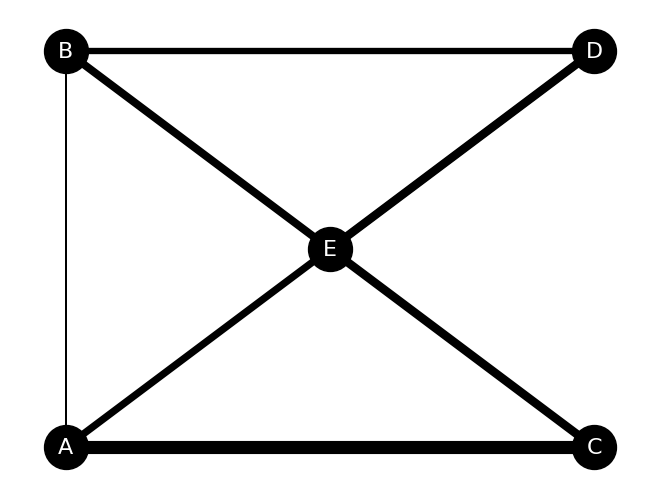

In [19]:
import numpy as np


# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_w.columns)):
    G.add_node(df_w.columns[i])

# 辺の設定&エッジの重みのリスト化
size = 10
edge_weights = []
num_pre = 0
for i in range(len(df_w.columns)):
    for j in range(len(df_w.columns)):
        if not (i==j):
            # 辺の追加
            G.add_edge(df_w.columns[i],df_w.columns[j])
            # 「書籍の間違い部分」
            # 上記のコードでエッジが追加されている場合のみ重みを追加する
            # 書籍のコードではこの部分がないため、変なところがつながってしまう
            if num_pre<len(G.edges):
              num_pre = len(G.edges)
              # エッジの重みの追加
              edge_weights.append(df_w.iloc[i, j]*size)

# 座標の設定
pos = {}
for i in range(len(df_w.columns)):
    node = df_w.columns[i]
    pos[node] = (df_p[node][0],df_p[node][1])

# 描画
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 表示
plt.show()

## ノック56 : 輸送ルート情報を読み込んでみる

In [20]:
# ルート情報の読み込み
df_tr = pd.read_csv('../input/python100knock-logistic/trans_route.csv', index_col='工場')
df_tr.head()

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


## ノック57 : 輸送ルート情報からネットワークを可視化する

In [21]:
# 各ノードの座標情報の読みこみ
df_pos = pd.read_csv('../input/python100knock-logistic/trans_route_pos.csv')
df_pos.head()

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


In [22]:
# 倉庫と工場間の輸送コスト
df_cost = pd.read_csv('../input/python100knock-logistic/trans_cost.csv')
df_cost.head()

,工場,F1,F2,F3,F4
0,W1,10,10,11,27
1,W2,18,21,12,14
2,W3,15,12,14,12


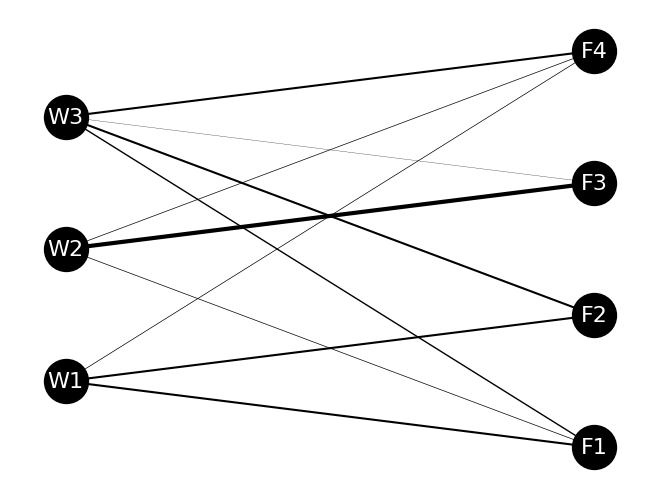

In [23]:
# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 辺の設定&エッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 辺の追加
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # エッジの重みの追加
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
                

# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
# 描画
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 表示
plt.show()

                
        

どの倉庫からどの工場へも輸送が行われている。<br>輸送コストを考えるのなら、輸送が多い場所に集約させた方が（一気に運べるので）輸送コストは下がるのでは。

## ノック58 : 輸送コスト関数を作成しよう

* ## 最適化問題の解き方

### 1.  最大化、最小化したいものを関数として定義（「目的関数」と呼ぶ）
### 2.  最大化、最小化を行うにあたって守るべき条件を定義する（「制約条件」と呼ぶ）

* ### 今回の目的関数の形 
あるルート$k$の輸送量を$w_k$、輸送コストを$c_k$として、目的関数$W$は次の形で定義される。

$$ W = \sum^k w_k c_k$$ 

In [24]:
# データ読み込み
df_tr = pd.read_csv('../input/python100knock-logistic/trans_route.csv', index_col='工場')
df_tc = pd.read_csv('../input/python100knock-logistic/trans_cost.csv', index_col='工場')

# 輸送コスト関数
def trans_cost(df_tr, df_tc):
    cost = 0
    for i in range(len(df_tc.index)):
        for j in range(len(df_tr.columns)):
            cost += df_tr.iloc[i, j]*df_tc.iloc[i, j]
    
    return cost

print('総輸送コスト : ' + str(trans_cost(df_tr, df_tc)))


総輸送コスト : 1493


## ノック59 : 制約条件の作成

* #### 各倉庫には供給可能な部品数の上限がある。また、各工場には満たすべき最低限の製品生産量がある。
* #### それぞれを格納したデータを読み込み、制約条件を満たすかどうか確認する。
倉庫の供給量 : supply.csv<br>
工場の製品製造料 : demand.csv

In [25]:
# データ読み込み
df_tr = pd.read_csv('../input/python100knock-logistic/trans_route.csv', index_col='工場') 
df_demand = pd.read_csv('../input/python100knock-logistic/demand.csv')
df_supply = pd.read_csv('../input/python100knock-logistic/supply.csv')

#輸送ルートと輸送されている商品の個数が格納されたデータ
df_tr.head()

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


* ### コメント 
#### つまり、縦に全部足すと各工場（F1,F2,,,）への輸送量に、横に全部足すと各倉庫の総供給量になっている。
#### この本では暗黙のうちに部品一個につき一個製品が製造されると仮定されているみたい（どこかに書いてあったかも）なので、工場に運び込まれた製品の数 = 製造される製品の数　に対応している。


In [26]:
# データの中身の確認
df_demand.head()

,F1,F2,F3,F4
0,28,29,31,25


In [27]:
# 供給量データの中身
df_supply.head()

,W1,W2,W3
0,35,41,42


In [28]:
# 需要側（工場が必要な部品の個数）の制約条件
for i in range(len(df_demand.columns)):
    part_sum_tmp = sum(df_tr[df_demand.columns[i]])
    print(str(df_demand.columns[i]) + 'への輸送量 : ' + str(part_sum_tmp) + '（需要量 : '
         + str(df_demand.iloc[0, i]) + '）')
    
    if part_sum_tmp >= df_demand.iloc[0, i]:
        print('需要量（部品の必要量）を満たしています。')
    else:
        print('需要量（部品の必要量）を満たしていません。輸送ルートを再計算してください。')


# 供給側（倉庫から出荷できる部品）の制約条件
for i in range(len(df_supply.columns)):
    part_sum_tmp = sum(df_tr.loc[df_supply.columns[i]])
    print(str(df_supply.columns[i]) + 'からの輸送量 : ' + str(part_sum_tmp) + '（供給限界 : ' 
         + str(df_supply.iloc[0, i]) + '）')
    if part_sum_tmp <= df_supply.iloc[0, i]:
        print('供給限界の範囲内です。')
    else:
        print('供給限界を超えています。輸送ルートを再計算してください。')
    

F1への輸送量 : 30（需要量 : 28）
需要量（部品の必要量）を満たしています。
F2への輸送量 : 30（需要量 : 29）
需要量（部品の必要量）を満たしています。
F3への輸送量 : 32（需要量 : 31）
需要量（部品の必要量）を満たしています。
F4への輸送量 : 25（需要量 : 25）
需要量（部品の必要量）を満たしています。
W1からの輸送量 : 35（供給限界 : 35）
供給限界の範囲内です。
W2からの輸送量 : 40（供給限界 : 41）
供給限界の範囲内です。
W3からの輸送量 : 42（供給限界 : 42）
供給限界の範囲内です。


## ノック60 : 輸送ルートを変更して輸送コスト関数の変化を確認する

trans_route_new.csvに記載された新しいルートが制約条件を満たしているのか、どれくらいのコストの改善が見込めるのか計算してみる。

In [29]:
# データ読み込み
df_tr_new = pd.read_csv('../input/python100knock-logistic/trans_route_new.csv', index_col='工場')
df_tr_new

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,0
W2,5,0,30,10
W3,10,15,2,15


In [30]:
# 旧データと比較してみる
df_tr

,F1,F2,F3,F4
工場,,,,
W1,15,15,0,5
W2,5,0,30,5
W3,10,15,2,15


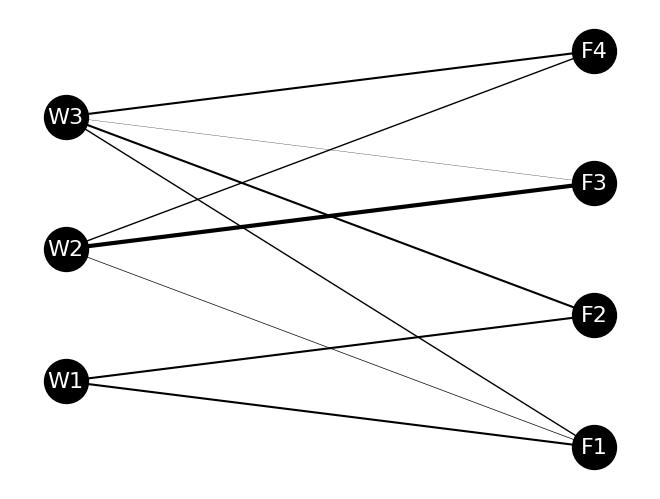

In [31]:
# 新ルートのグラフも表示してみる

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])

# 辺の設定&エッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 辺の追加
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # エッジの重みの追加
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr_new.columns)and(df_pos.columns[j] in df_tr_new.index):
                    if df_tr_new[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr_new[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr_new.columns)and(df_pos.columns[i] in df_tr_new.index):
                    if df_tr_new[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr_new[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)
                

# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
# 描画
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)

# 表示
plt.show()


少しルートが変わっているのが見える（例えばW1から出るエッジが3から2に減っている）

* #### 総輸送コスト再計算

In [32]:
print('総輸送コスト（変更後） : ' + str(trans_cost(df_tr_new, df_tc)) + '万円')

総輸送コスト（変更後） : 1428万円


（元の輸送コストは1433万円）

* #### 制約条件計算関数

In [33]:
# 需要を満たしているかどうか判定する
def condition_demand(df_tr, df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        part_sum_tmp = sum(df_tr[df_demand.columns[i]])
        if part_sum_tmp >= df_demand.iloc[0, i]:
            flag[i] = 1
    return flag

# 供給限界の範囲内か判定する
def condition_supply(df_tr, df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        part_sum_tmp = sum(df_tr.loc[df_supply.columns[i]])
        if part_sum_tmp <= df_supply.iloc[0, i]:
            flag[i] = 1
    return flag

print('需要条件計算結果 : ' + str(condition_demand(df_tr_new, df_demand)))
print('供給条件計算結果 : ' + str(condition_supply(df_tr_new, df_supply)))

需要条件計算結果 : [1. 1. 1. 1.]
供給条件計算結果 : [1. 0. 1.]


新ルートではW2（倉庫2）の供給限界を超えてしまった。